<font color='green' size=6>**Цель данного ноутбука**: сравнить методы классификации SVM, logistic regression и knn classification

In [1]:
import numpy as np
import pandas as pd


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import seaborn as sns

import zipfile

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:.5f}'.format
pd.options.mode.use_inf_as_na = True



%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Загрузка датасетов

In [3]:
from google.colab import drive
import json
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# установим kaggle
!pip install kaggle -q

In [5]:
!mkdir ~/.kaggle

In [6]:
# копируем kaggle.json в папку ~/.kaggle/
!cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/

In [7]:
# https://www.kaggle.com/competitions/playground-series-s3e12/data?s
# elect=train.csv

!kaggle competitions download -c playground-series-s3e12

zip_ref = zipfile.ZipFile('playground-series-s3e12.zip', 'r')
zip_ref.extractall()
zip_ref.close()
df = pd.read_csv('train.csv')
X = df.drop(columns=['id', 'target'])
y = df['target']

  0% 0.00/9.06k [00:00<?, ?B/s]
100% 9.06k/9.06k [00:00<00:00, 12.2MB/s]


In [8]:
# https://www.kaggle.com/competitions/playground-series-s3e10/data?s
# elect=train.csv

# !kaggle competitions download -c playground-series-s3e10
# # разархивируем
# print('а теперь будем разархивировать')
# zip_ref = zipfile.ZipFile('playground-series-s3e10.zip', 'r')
# zip_ref.extractall()
# zip_ref.close()
# # считаем данные
# df = pd.read_csv('train.csv')
# X = df.drop(columns=['id', 'Class'])
# y = df['Class']


In [9]:
# # https://www.kaggle.com/competitions/playground-series-s4e7
# !kaggle competitions download -c playground-series-s4e7
# # разархивируем
# print('а теперь будем разархивировать')
# zip_ref = zipfile.ZipFile('playground-series-s4e7.zip', 'r')
# zip_ref.extractall()
# zip_ref.close()
# # считаем данные
# df = pd.read_csv('train.csv')
# X = df.drop(columns=['id', 'Response'])
# y = df['Response']

In [10]:
X = X.select_dtypes(include='number')

#EDA

In [11]:
# Размер датасета
print(f"В датасете: {X.shape[0]} строк")

# Information about columns and data types
print(f"\n В датасете {X.shape[1]} столбцов, из них :")
print(X.dtypes.value_counts())

В датасете: 414 строк

 В датасете 6 столбцов, из них :
float64    4
int64      2
Name: count, dtype: int64


In [12]:
X.dtypes

gravity    float64
ph         float64
osmo         int64
cond       float64
urea         int64
calc       float64
dtype: object

In [13]:
print("\n Статистика по столбцам:")
X.describe().T


 Статистика по столбцам:


,count,mean,std,min,25%,50%,75%,max
gravity,414.00000,1.01789,0.00667,1.00500,1.01200,1.01800,1.02200,1.04000
ph,414.00000,5.95546,0.64226,4.76000,5.53000,5.74000,6.28000,7.94000
osmo,414.00000,651.54589,234.67657,187.00000,455.25000,679.50000,840.00000,1236.00000
cond,414.00000,21.43792,7.51475,5.10000,15.50000,22.20000,27.60000,38.00000
urea,414.00000,278.65700,136.44225,10.00000,170.00000,277.00000,385.00000,620.00000
calc,414.00000,4.11464,3.21764,0.17000,1.45000,3.13000,6.63000,14.34000


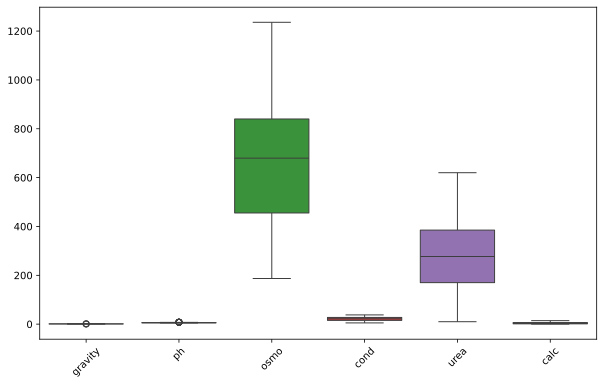

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.show()

In [15]:
# распределение целевой
print("\nTarget Class Distribution:")
pd.Series(y).value_counts()



Target Class Distribution:


target
0    230
1    184
Name: count, dtype: int64

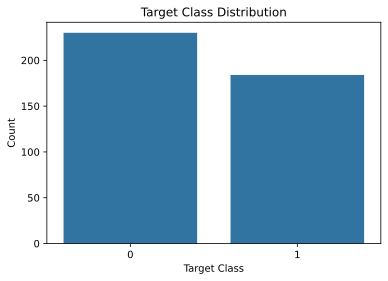

In [16]:
# Bar plot for target class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=pd.Series(y))
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Target Class Distribution')
plt.show()

In [17]:
# Проанализируем взаимосвязи между переменными
# sns.pairplot(X)
# plt.show()

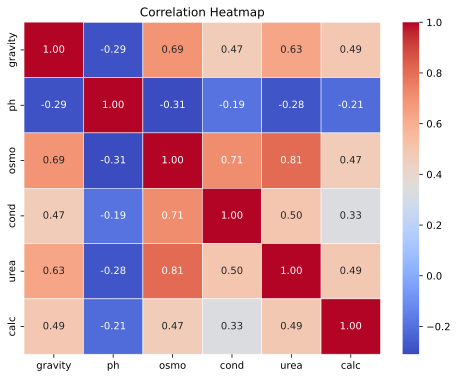

In [18]:
# Построим матрицу корреляций
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [19]:
X.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], dtype='object')

In [20]:
# Перекодировка
y_bin = y
#  (data["target"] == 1).astype(int)

In [21]:
X

,gravity,ph,osmo,cond,urea,calc
0,1.01300,6.19000,443,14.80000,124,1.45000
1,1.02500,5.40000,703,23.60000,394,4.18000
2,1.00900,6.13000,371,24.50000,159,9.04000
3,1.02100,4.91000,442,20.80000,398,6.63000
4,1.02100,5.53000,874,17.80000,385,2.21000
...,...,...,...,...,...,...
409,1.01100,5.21000,527,21.40000,75,1.53000
410,1.02400,5.53000,577,19.70000,224,0.77000
411,1.01800,6.28000,455,22.20000,270,7.68000
412,1.00800,7.12000,325,12.60000,75,1.03000


In [22]:
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, train_size=0.6, stratify=y_bin)




In [23]:
# Нормировка признаков
ss = StandardScaler() # (x-m)/sigma

X_train = ss.fit_transform(X_train)

X_test = ss.transform(X_test)

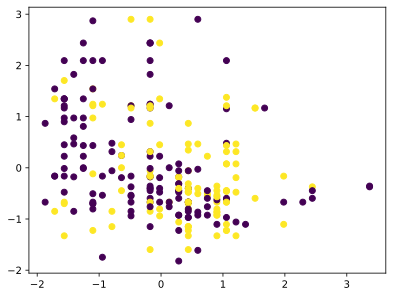

In [24]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);

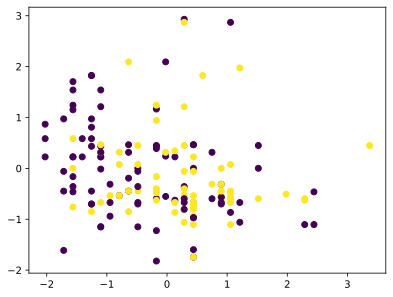

In [25]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test);

In [26]:


def calculate_metrics_and_plot_roc(model, X_train, y_train, X_test, y_test):
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание вероятностей на обучающей и тестовой выборке
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Расчет AUC-ROC
    roc_auc_train = roc_auc_score(y_train, y_train_proba)
    roc_auc_test = roc_auc_score(y_test, y_test_proba)
    print(f"ROC-AUC Train: {roc_auc_train:.2f}")
    print(f"ROC-AUC Test: {roc_auc_test:.2f}")

    # Построение ROC-кривой
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC Curve Train')
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC Curve Test')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({type(model).__name__})')
    plt.legend()
    plt.show()

    # Поиск порога, максимизирующего F1-score
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = [f1_score(y_test, y_test_proba >= t) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal Threshold: {optimal_threshold:.2f}")

    # Пересчет метрик с учетом оптимального порога
    y_train_pred_optimal = (y_train_proba >= optimal_threshold).astype(int)
    y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

    train_precision = precision_score(y_train, y_train_pred_optimal)
    train_recall = recall_score(y_train, y_train_pred_optimal)
    test_precision = precision_score(y_test, y_test_pred_optimal)
    test_recall = recall_score(y_test, y_test_pred_optimal)

    print(f"Optimal Training Precision: {train_precision:.2f}")
    print(f"Optimal Training Recall: {train_recall:.2f}")
    print(f"Optimal Test Precision: {test_precision:.2f}")
    print(f"Optimal Test Recall: {test_recall:.2f}")

    metrics = {
        'params': [
            'Training_Precision', 'Test_Precision',
            'Training_Recall', 'Test_Recall',
            'ROC_AUC_Train', 'ROC_AUC_Test'
        ],
        'values': [
            train_precision, test_precision,
            train_recall, test_recall,
            roc_auc_train, roc_auc_test
        ]
    }

    return metrics


# Models

In [27]:
# Построение модели k-Nearest Neighbors (kNN)
knn_model = KNeighborsClassifier()

In [28]:
# Задаем сетку параметров для значения "n_neighbors", которое мы хотим исследовать
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 14]}  # Пример значений, можно изменить диапазон по необходимости

# Создаем объект GridSearchCV с моделью KNN и сеткой параметров
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='roc_auc')  # Параметр cv определяет количество фолдов в кросс-валидации

# Обучаем модель на данных с помощью кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее найденное значение параметра "n_neighbors" в результате кросс-валидации
best_n_neighbors = grid_search.best_params_['n_neighbors']
print('best_n_neighbors =', best_n_neighbors)


best_n_neighbors = 11


In [29]:
best_knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)

In [30]:
best_knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

ROC-AUC Train: 0.81
ROC-AUC Test: 0.79


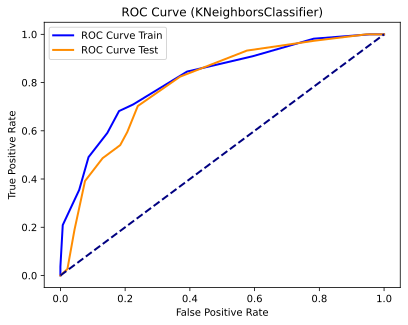

Optimal Threshold: 0.28
Optimal Training Precision: 0.63
Optimal Training Recall: 0.85
Optimal Test Precision: 0.64
Optimal Test Recall: 0.82


In [31]:
metrics_knn = calculate_metrics_and_plot_roc(best_knn_model, X_train, y_train, X_test, y_test)

## поиск параметров

In [32]:
%%time
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 20, 30, 50, 100],
              'penalty': ['l2','l1',],
              }

# Создаем модель логистической регрессии
logreg_model = LogisticRegression(solver='saga', max_iter = 100000)

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(logreg_model,
                           param_grid,
                           cv=5, # cv указывает количество блоков для кросс-валидации
                           scoring='roc_auc')

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


Лучшее значение параметра: {'C': 0.1, 'penalty': 'l1'}
CPU times: user 695 ms, sys: 14 ms, total: 709 ms
Wall time: 1.97 s


In [33]:
%%time
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 20, 30, 50, 100],
              'penalty': ['l2', 'l1'],
              }

# Создаем модель логистической регрессии
logreg_model = LogisticRegression(solver='saga', max_iter=100000)

# Создаем объект RandomizedSearchCV с моделью логистической регрессии и сеткой параметров
random_search = RandomizedSearchCV(logreg_model,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=5, scoring='roc_auc')

# Обучаем модель на данных с использованием кросс-валидации
random_search.fit(X_train, y_train)

# Получаем лучшее значение параметров, найденных в процессе кросс-валидации
print('Лучшие значения параметров:', random_search.best_params_)


Лучшие значения параметров: {'penalty': 'l1', 'C': 0.1}
CPU times: user 412 ms, sys: 14.2 ms, total: 426 ms
Wall time: 1.03 s


In [34]:

# Построение модели логистической регрессии
logreg_model = LogisticRegression(solver='saga',  max_iter=1000, **grid_search.best_params_)
# plot_decision_boundary(logreg_model, X_train, y_train)

In [35]:
logreg_model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='saga')

In [36]:
logreg_model.coef_

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.95262318]])

ROC-AUC Train: 0.79
ROC-AUC Test: 0.79


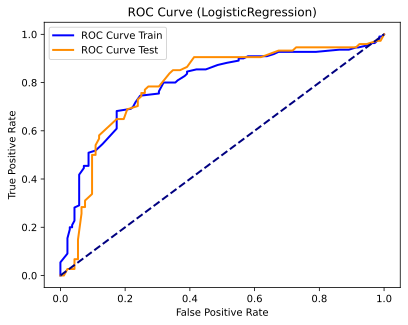

Optimal Threshold: 0.30
Optimal Training Precision: 0.56
Optimal Training Recall: 0.90
Optimal Test Precision: 0.63
Optimal Test Recall: 0.91


In [37]:
metrics_logreg  = calculate_metrics_and_plot_roc(logreg_model, X_train, y_train, X_test, y_test)

In [38]:
from sklearn.svm import SVC
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              }

# Создаем модель логистической регрессии
svm_model = SVC(kernel='linear', C=0.0)

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(svm_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


# Создаем модель логистической регрессии с лучшим значением C
best_svm_model = SVC(kernel='linear',probability=True, **grid_search.best_params_)

Лучшее значение параметра: {'C': 1}


ROC-AUC Train: 0.80
ROC-AUC Test: 0.79


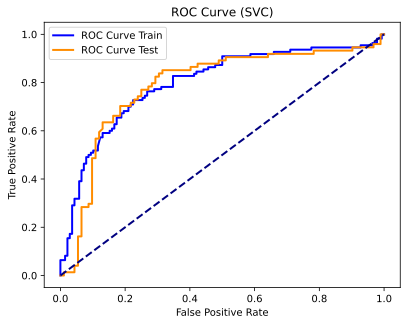

Optimal Threshold: 0.31
Optimal Training Precision: 0.61
Optimal Training Recall: 0.85
Optimal Test Precision: 0.69
Optimal Test Recall: 0.84


In [39]:
metrics_svm_linear  = calculate_metrics_and_plot_roc(best_svm_model, X_train, y_train, X_test, y_test)

In [40]:
from sklearn.svm import SVC
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1],
              'kernel':['linear', 'poly', 'rbf', 'sigmoid',]
              }

svm_model = SVC(kernel='linear')

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(svm_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


# Создаем модель с лучшим значением C
best_svm_model = SVC(**grid_search.best_params_, probability=True)

Лучшее значение параметра: {'C': 1, 'kernel': 'rbf'}


ROC-AUC Train: 0.84
ROC-AUC Test: 0.81


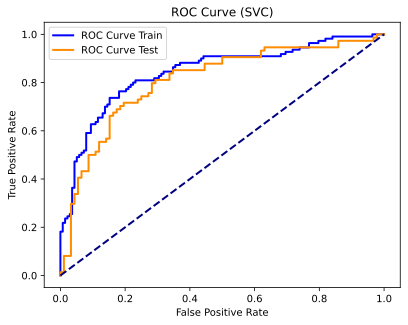

Optimal Threshold: 0.30
Optimal Training Precision: 0.68
Optimal Training Recall: 0.83
Optimal Test Precision: 0.69
Optimal Test Recall: 0.81


In [41]:
metrics_svm_not_linear  = calculate_metrics_and_plot_roc(best_svm_model, X_train, y_train, X_test, y_test)

**Соберем все результаты в одну таблицу, чтобы было проще сравнивать алгоритмы**

In [42]:
metrics_svm_not_linear['metrics'] = ['metrics_svm_not_linear' for i in range(6)]

metrics_svm_linear['metrics'] = ['metrics_svm_linear' for i in range(6)]

metrics_logreg['metrics'] = ['metrics_logreg' for i in range(6)]
metrics_knn['metrics'] = ['metrics_knn' for i in range(6)]

In [43]:
df_stat = pd.concat([pd.DataFrame(metrics_svm_not_linear),
                    pd.DataFrame(metrics_svm_linear),
                    pd.DataFrame(metrics_logreg),
                    pd.DataFrame(metrics_knn)])

In [44]:
df_stat = df_stat.pivot_table(columns = 'params',
                            index='metrics',
                            values='values').reset_index()[['metrics','Test_Precision',	'Training_Precision',
                                                            'Test_Recall',	'Training_Recall', 'ROC_AUC_Train', 'ROC_AUC_Test']]
df_stat['dif_Precision'] = round((df_stat['Test_Precision'] - df_stat['Training_Precision'])/df_stat['Training_Precision'],2)

df_stat['dif_Recall'] = round((df_stat['Test_Recall'] - df_stat['Training_Recall'])/df_stat['Training_Recall'],2)
df_stat

params,metrics,Test_Precision,Training_Precision,Test_Recall,Training_Recall,ROC_AUC_Train,ROC_AUC_Test,dif_Precision,dif_Recall
0,metrics_knn,0.64211,0.63265,0.82432,0.84545,0.81357,0.79032,0.01000,-0.02000
1,metrics_logreg,0.62617,0.55932,0.90541,0.90000,0.79147,0.79150,0.12000,0.01000
2,metrics_svm_linear,0.68889,0.61184,0.83784,0.84545,0.79677,0.78621,0.13000,-0.01000
3,metrics_svm_not_linear,0.68966,0.68421,0.81081,0.82727,0.84216,0.80699,0.01000,-0.02000


In [45]:
df_stat['abs_dif_precision'] = abs(df_stat['dif_Precision'])

In [46]:
df_stat.sort_values('abs_dif_precision', ascending=True).T

,0,3,1,2
params,,,,
metrics,metrics_knn,metrics_svm_not_linear,metrics_logreg,metrics_svm_linear
Test_Precision,0.64211,0.68966,0.62617,0.68889
Training_Precision,0.63265,0.68421,0.55932,0.61184
Test_Recall,0.82432,0.81081,0.90541,0.83784
Training_Recall,0.84545,0.82727,0.90000,0.84545
ROC_AUC_Train,0.81357,0.84216,0.79147,0.79677
ROC_AUC_Test,0.79032,0.80699,0.79150,0.78621
dif_Precision,0.01000,0.01000,0.12000,0.13000
dif_Recall,-0.02000,-0.02000,0.01000,-0.01000
